<a href="https://colab.research.google.com/github/shalinimaurya17/Modulation-Classification/blob/main/Resnet_2016_10A_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.io import loadmat
from pandas import factorize
import pickle
import pickle as pkl
import numpy as np
import pandas as pd
import random
from scipy import signal
import csv

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

In [ ]:
# RadioML2016.10a/10b or MIGOU MOD

def load_dataset(dataset_location):
    """
    Load dataset and extract needed data

    Input: 
        dataset_location: specify where the file is stored and its name

    Output:
        snrs: list of the SNR range in dataset [-20 to 18]
        X: array of the measured I/Q data [num_of_samples, 128, 2]
        modulations: list of the modulations in this dataset
        one_hot_encode: one_hot encoded data - the other maps the order of the mods
        lbl_SNR: list of each snr (for plotting)
    """

    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset_location.keys())))), [1,0])

    X = []; I = []; Q = []; lbl = [];

    for mod in mods:
        for snr in snrs:
            X.append(dataset_location[(mod,snr)])
            for i in range(dataset_location[(mod,snr)].shape[0]):  
                lbl.append((mod,snr))
    X = np.vstack(X); lbl=np.vstack(lbl)

    X = np.transpose(X[:,:,:],(0,2,1))

    # One-hot-encoding
    Y = [];
    for i in range(len(lbl)):
        mod = (lbl[i,0])
        Y.append(mod)

    mapping = {}
    for x in range(len(mods)):
        mapping[mods[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)

    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(mods)/len(snrs)
    repeat_n_mod = len(mods)    
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_mod)



    return snrs, X, mods, one_hot_encode, lbl_SNR
    

In [ ]:
def show_confusion_matrix(validations, predictions, matrix_snr, save=False):
    """
    Plot confusion matrix

    validations:    True Y labels
    predictions:    Predicted Y labels of your model
    matrix_snr:     SNR information for plot's titel
    """
  
    cm = confusion_matrix(validations, predictions)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', xticklabels=mods, yticklabels=mods)
    sns.set(font_scale=1.3)
    if matrix_snr == None:
        plt.title("Confusion Matrix")
    else:
        plt.title("Confusion Matrix \n" + str(matrix_snr) + "dB")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if save == True:
        plt.savefig(base_dir + 'Own_dataset/' + str(matrix_snr) + '.png')    
    plt.show(block=False)
    

In [ ]:
def All_SNR_show_confusion_matrix(X_test, save=False):
    """
    Plot confusion matrix of all SNRs in one

    X_test:   X_test data
    """
    prediction = model.predict(X_test)

    Y_Pred = []; Y_Test = [];

    for i in range(len(prediction[:,0])):
        Y_Pred.append(np.argmax(prediction[i,:]))
        Y_Test.append(np.argmax(Y_test[i]))

    show_confusion_matrix(Y_Pred, Y_Test, None, save)

In [ ]:
def train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15):
    
    """
    Train-Test split the data

    Input:
        X: X data
        one_hot: Y data encoded to one_hot
        train_split (default 0.7)
        valid_split (default 0.15)
        test_split (default 0.15)
        train_split : valid_split : test_split - ratio for splitting the dataset
        
        NOTE: the ratio split must be a sum of 1!

    Output:
        train_idx: indexes from X assinged to train data
        valid_idx: indexes from X assinged to validation data 
        test_idx: indexes from X assinged to test data
        X_train: X data assigned for training
        X_valid: X data assigned for validation
        X_test: X data assigned for testing
        Y_train: one-hot encoded Y data assigned for training
        Y_valid: one-hot encoded Y data assigned for validation
        Y_test: one-hot encoded Y data assigned for testing
    """

    # Set random seed
    np.random.seed(42)
    random.seed(42)

    # Get the number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * train_split)
    n_valid = int(n_examples * valid_split)
    n_test = int(n_examples * test_split)
    
    # Get indexes of train data
    train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)

    # Left indexes for valid and test sets
    left_idx= list(set(range(0, n_examples)) - set(train_idx))
    
    # Get indexes for the left indexes of the X data
    val = np.random.choice(range(0, (n_valid+n_test)), size=(n_valid), replace=False)
    test = list(set(range(0, len(left_idx))) - set(val))

    # Assign indeces for validation to left indexes
    valid_idx = []
    for i in val:
        val_idx = left_idx[i]
        valid_idx.append(val_idx)
    
    # Get the test set as the rest indexes
    test_idx = []
    for i in test:
        tst_idx = left_idx[i]
        test_idx.append(tst_idx)
    
    # Shuffle the valid_idx and test_idx
    random.shuffle(valid_idx)
    random.shuffle(test_idx)

    # Assing the indexes to the X and Y data to create train and test sets
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_test = X[test_idx]   
    Y_train = one_hot[train_idx]
    Y_valid = one_hot[valid_idx]
    Y_test = one_hot[test_idx]  

    return train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test



In [ ]:
def normalize_data(X_train, X_valid, X_test):
        # mean-std normalization

    mean = X_train[:,:,:].mean(axis=0)
    X_train[:,:,:] -= mean
    std = X_train[:,:,:].std(axis=0)
    X_train[:,:,:] /= std


    X_valid[:,:,:] -= mean
    X_valid[:,:,:] /= std

    X_test[:,:,:] -= mean
    X_test[:,:,:] /= std

    return X_train, X_valid, X_test

In [ ]:
def return_indices_of_a(a, b):
    """
    Compare two lists a, b for same items and return indeces
    of the item in list a

    a:    List of items, its indeces will be returned
    b:    List of items to search for in list a

    Credit: https://stackoverflow.com/users/97248/pts ; https://stackoverflow.com/questions/10367020/compare-two-lists-in-python-and-return-indices-of-matched-values
    """
    b_set = set(b)
    return [i for i, v in enumerate(a) if v in b_set]

In [ ]:
def plot_split_distribution(mods, Y_train, Y_valid, Y_test):

    x = np.arange(len(mods))  # the label locations
    width = 1  # the width of the bars

    fig, ax = plt.subplots()
    bar1 = ax.bar(x-width*0.3, np.count_nonzero(Y_train == 1, axis=0), width*0.3, label = "Train" )
    bar2 = ax.bar(x , np.count_nonzero(Y_valid == 1, axis=0), width*0.3, label = "Valid" )
    bar3 = ax.bar(x+width*0.3, np.count_nonzero(Y_test == 1, axis=0), width*0.3, label = "Test" )


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Distribution')
    ax.set_title('Distribution overview of splitted dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(mods)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 0),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            
    # autolabel(bar1)
    # autolabel(bar2)
    # autolabel(bar3)
    # fig.tight_layout()
    return plt.show()

In [ ]:
def SNR_accuracy(in_snr, name):
    """
    Computes accuracies of chosen SNRs individualy
  
    in_snr:   must be list of SNRs
    """
    
    acc = []
    for snr in in_snr:
        acc_snr = snr
        idx_acc_snr = []

        for i in range(len(test_idx)):
            if int(lbl_SNR[test_idx[i]]) == int(acc_snr):
                idx_acc_snr.append(i)

        acc_X_test = X_test[idx_acc_snr]
        # acc_X_f_test = X_f_test[idx_acc_snr]
        acc_Y_test = Y_test[idx_acc_snr]

        print('\nSNR ' + str(acc_snr) + 'dB:')
        accuracy_snr = model.evaluate([acc_X_test], acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)

    acc = np.vstack(acc)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(SNR, (acc[:,1]*100), 'steelblue', marker='.', markersize= 15, label = name, linestyle = '-',)
    ax.legend(loc=4, prop={'size': 25})

    x_major_ticks = np.arange(-20, 19, 2 )
    ax.set_xticks(x_major_ticks)

    y_major_ticks = np.arange(0, 101, 10 )
    y_minor_ticks = np.arange(0, 101, 2)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.grid(which='both',color='lightgray', linestyle='-')

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    plt.xlim(-20, 18)
    plt.ylim(0,100)
    plt.title("Classification Accuracy",fontsize=20)
    plt.ylabel('Accuracy (%)',fontsize=20)
    plt.xlabel('SNR (dB)',fontsize=20)
    # plt.savefig(base_dir + name + '.png') 
    plt.show()

    return acc[:,1]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


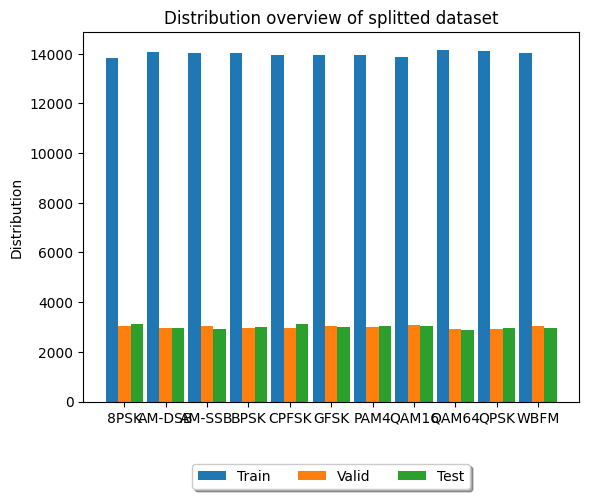

In [ ]:
dataset_pkl = open('/content/drive/MyDrive/Colab Notebooks/RML2016.10a_dict.pkl','rb')
RML_dataset_location = pickle.load(dataset_pkl, encoding='bytes')

SNR, X, modulations, one_hot, lbl_SNR = load_dataset(RML_dataset_location)

mods = []
for i in range(len(modulations)):
    modu = modulations[i].decode('utf-8')
    mods.append(modu)

train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15)
plot_split_distribution(mods, Y_train, Y_valid, Y_test)



In [ ]:
from keras.datasets import cifar10
from keras.utils import np_utils
from keras import metrics, Model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, LSTM, Input, Add, Reshape, Dropout
from keras import metrics
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD
import pickle
import matplotlib.pyplot as plt
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping

def resnet(x_shape):
    x = Input(x_shape)
    y = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    y = Dropout(0.20)(y)
    y = Conv2D(256, (3, 3), activation='relu', padding='same')(y)   
    z = Add()([x, y])
    z = Conv2D(256, (3, 3),activation='relu', padding='same')(z)
    z = Conv2D(256, (3, 3),activation='relu', padding='same')(z)
    z = Dropout(0.20)(z)
    z = Conv2D(128, (2, 3), activation='relu',padding='same')(z)
    z = Dropout(0.20)(z)
    z = Conv2D(80, (1, 3), activation='relu', padding='same')(z)
    z = Dropout(0.20)(z)
    z = Conv2D(80, (1, 3), activation='relu', padding='same')(z)
    z = Dropout(0.20)(z)

    z = Conv2D(64, (1, 3),activation='relu', padding='same')(z)
  
    z = Add()([z,x])
   

    zz = Flatten()(z)
    z = Dense(128, activation='relu')(zz)
    z = Dropout(0.20)(z)
    print(z.shape)
    z = Dense(11, activation='softmax')(z)
    print(z.shape)
    model = Model(x,z)
    return model




In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, min_lr=0.00007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)]

optimizer = keras.optimizers.Adam(learning_rate=0.0007)
shape=(128,2,1)
modelsa=resnet(shape)
modelsa.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


(None, 128)
(None, 11)


In [ ]:
modelsa.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 2, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 128, 2, 256)  2560        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128, 2, 256)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 2, 256)  590080      ['dropout[0][0]']                
                                                                                              

In [ ]:
tf.keras.backend.clear_session()
history = modelsa.fit(X_train, Y_train, batch_size=128, epochs=10, verbose=2, validation_data= (X_valid, Y_valid), callbacks=callbacks)


Epoch 1/10
1204/1204 - 155s - loss: 1.6998 - accuracy: 0.3535 - val_loss: 1.4558 - val_accuracy: 0.4398 - lr: 7.0000e-04 - 155s/epoch - 128ms/step
Epoch 2/10
1204/1204 - 137s - loss: 1.3580 - accuracy: 0.4751 - val_loss: 1.2806 - val_accuracy: 0.5092 - lr: 7.0000e-04 - 137s/epoch - 114ms/step
Epoch 3/10
1204/1204 - 137s - loss: 1.2714 - accuracy: 0.5112 - val_loss: 1.2684 - val_accuracy: 0.5206 - lr: 7.0000e-04 - 137s/epoch - 114ms/step
Epoch 4/10
1204/1204 - 137s - loss: 1.2256 - accuracy: 0.5333 - val_loss: 1.2313 - val_accuracy: 0.5204 - lr: 7.0000e-04 - 137s/epoch - 114ms/step
Epoch 5/10
1204/1204 - 137s - loss: 1.1899 - accuracy: 0.5488 - val_loss: 1.2194 - val_accuracy: 0.5394 - lr: 7.0000e-04 - 137s/epoch - 114ms/step
Epoch 6/10
1204/1204 - 137s - loss: 1.1561 - accuracy: 0.5651 - val_loss: 1.2030 - val_accuracy: 0.5542 - lr: 7.0000e-04 - 137s/epoch - 114ms/step
Epoch 7/10
1204/1204 - 137s - loss: 1.1226 - accuracy: 0.5793 - val_loss: 1.2002 - val_accuracy: 0.5569 - lr: 7.0000e-

In [ ]:
model = keras.models.load_model("model.h5")

test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

1032/1032 [==============================] - 10s 9ms/step - loss: 1.2040 - accuracy: 0.5563
Test accuracy 0.5563333630561829
Test loss 1.2039786577224731



SNR -20dB:
50/50 - 1s - loss: 2.5938 - accuracy: 0.0951 - 776ms/epoch - 16ms/step

SNR -18dB:
52/52 - 1s - loss: 2.5991 - accuracy: 0.0946 - 664ms/epoch - 13ms/step

SNR -16dB:
53/53 - 1s - loss: 2.5359 - accuracy: 0.1055 - 702ms/epoch - 13ms/step

SNR -14dB:
54/54 - 1s - loss: 2.3870 - accuracy: 0.1310 - 728ms/epoch - 13ms/step

SNR -12dB:
50/50 - 0s - loss: 2.2370 - accuracy: 0.1775 - 456ms/epoch - 9ms/step

SNR -10dB:
53/53 - 0s - loss: 2.0430 - accuracy: 0.2476 - 440ms/epoch - 8ms/step

SNR -8dB:
52/52 - 1s - loss: 1.7511 - accuracy: 0.3484 - 552ms/epoch - 11ms/step

SNR -6dB:
52/52 - 1s - loss: 1.4094 - accuracy: 0.4448 - 613ms/epoch - 12ms/step

SNR -4dB:
53/53 - 0s - loss: 1.1206 - accuracy: 0.5568 - 450ms/epoch - 8ms/step

SNR -2dB:
52/52 - 1s - loss: 0.8438 - accuracy: 0.6409 - 647ms/epoch - 12ms/step

SNR 0dB:
52/52 - 1s - loss: 0.5954 - accuracy: 0.7623 - 571ms/epoch - 11ms/step

SNR 2dB:
51/51 - 0s - loss: 0.5160 - accuracy: 0.8109 - 431ms/epoch - 8ms/step

SNR 4dB:
52/52 

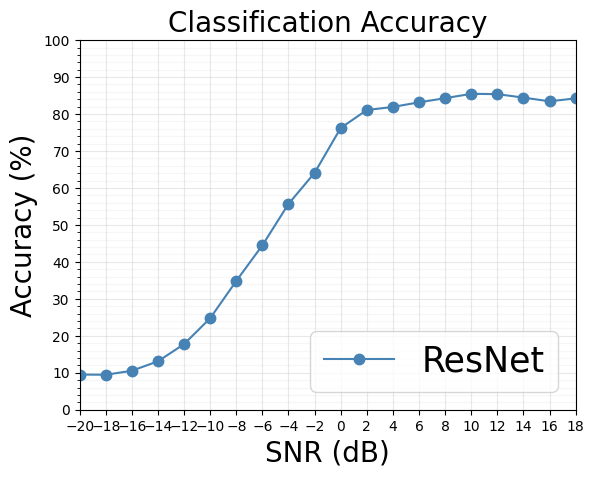

array([0.09514808, 0.09460279, 0.10545024, 0.1310145 , 0.17749999,
       0.24761905, 0.34838316, 0.44484848, 0.55681139, 0.6409173 ,
       0.76234001, 0.81087762, 0.81923312, 0.83169532, 0.84292865,
       0.85465467, 0.85383677, 0.84448463, 0.83445328, 0.84238178])

In [ ]:
SNR_accuracy(SNR, 'ResNet')

1032/1032 [==============================] - 8s 8ms/step


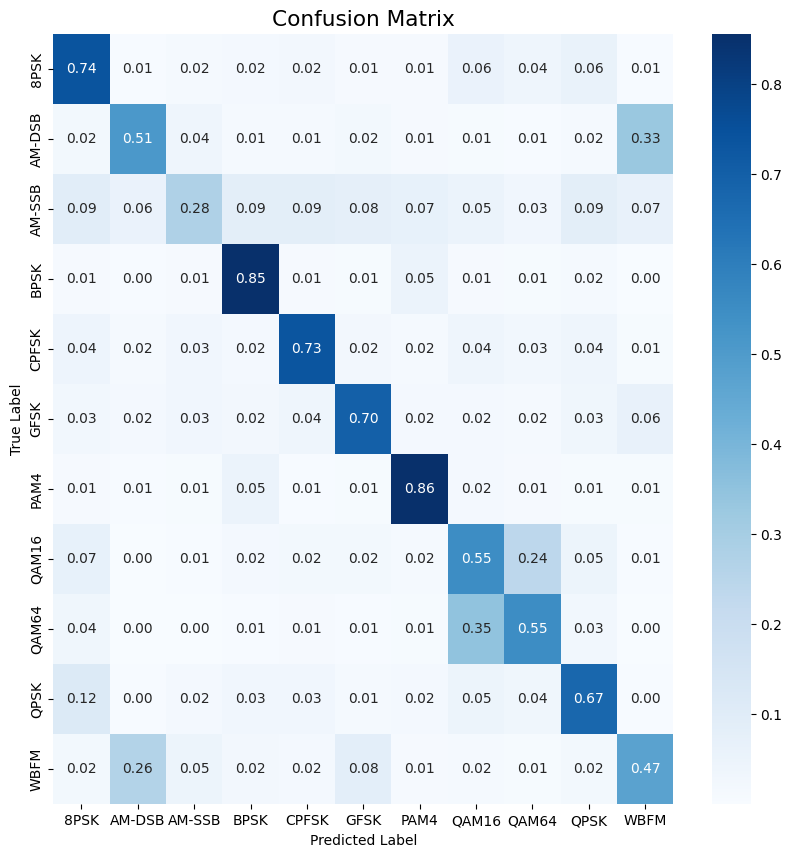

In [ ]:
All_SNR_show_confusion_matrix([X_test], save=False)